# Classical Multi-Armed Bandit → Quantum Decision Model


In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.


### Cell 1 — Imports & Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pennylane as qml

import time

### Cell 2 — Bandit Environment (Shared, Controlled)

In [3]:
N_ARMS = 3
TIME_STEPS = 300

# True reward probabilities (unknown to agents)
ARM_PROBS = [0.2, 0.5, 0.8]

def pull_arm(arm):
    return 1 if np.random.rand() < ARM_PROBS[arm] else 0


### Cell 3 — Metrics Template (SVM-STYLE)

In [4]:
metrics_classical = {
    "progress": [],
    "performance": [],
    "actions": [],            # action taken at each timestep
    "rewards": [],            # reward received at each timestep
    "cumulative_regret": []   # cumulative regret over time
}

metrics_quantum = {
    "progress": [],
    "performance": [],
    "actions": [],
    "rewards": [],
    "cumulative_regret": [],
    "circuit_exec_time_s": [] # quantum circuit execution time per timestep (seconds)
}

best_arm_prob = float(np.max(ARM_PROBS))


## CLASSICAL ε-GREEDY BANDIT

### Cell 4 — Classical Agent Initialization

In [5]:
Q = np.zeros(N_ARMS)
epsilon = 0.1
alpha = 0.1


### Cell 5 — Classical Training Loop (WITH METRICS)

In [6]:
cumulative_reward = 0
cumulative_regret = 0.0

for t in range(TIME_STEPS):

    # ε-greedy action selection
    if np.random.rand() < epsilon:
        action = np.random.randint(N_ARMS)
    else:
        action = np.argmax(Q)

    reward = pull_arm(action)

    # Q-value update
    Q[action] += alpha * (reward - Q[action])

    cumulative_reward += reward

    # Regret: difference between best expected reward and chosen arm expected reward
    instant_regret = best_arm_prob - ARM_PROBS[action]
    cumulative_regret += instant_regret

    # 🔴 METRIC COLLECTION (SVM-STYLE)
    metrics_classical["progress"].append(t)
    metrics_classical["performance"].append(cumulative_reward)
    metrics_classical["actions"].append(action)
    metrics_classical["rewards"].append(reward)
    metrics_classical["cumulative_regret"].append(cumulative_regret)


## QUANTUM BANDIT (VARIATIONAL POLICY)

### Cell 6 — Quantum Policy Circuit

We model action preference using a variational quantum circuit.

In [7]:
N_QUBITS = 3
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_policy(state, weights):
    qml.AngleEmbedding(state, wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


### Cell 7 — Quantum Parameters & Optimizer

In [8]:
weights = torch.nn.Parameter(torch.randn(2, N_QUBITS))
optimizer = torch.optim.Adam([weights], lr=0.1)


### Cell 8 — Quantum Training Loop (WITH METRICS)

We treat the bandit as a stateless decision problem and learn a quantum policy that biases toward high-reward arms.

In [9]:
cumulative_reward = 0
cumulative_regret = 0.0

for t in range(TIME_STEPS):

    # Dummy state (bandit has no true state)
    state = torch.rand(N_QUBITS)

    # ⏱️ Quantum circuit execution time (forward pass)
    t0 = time.perf_counter()
    logits = torch.stack(quantum_policy(state, weights))
    t1 = time.perf_counter()
    metrics_quantum["circuit_exec_time_s"].append(t1 - t0)

    probs = torch.softmax(logits, dim=0)

    action = torch.multinomial(probs, 1).item()
    reward = pull_arm(action)

    # Policy gradient–style update
    loss = -torch.log(probs[action]) * reward

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cumulative_reward += reward

    # Regret: difference between best expected reward and chosen arm expected reward
    instant_regret = best_arm_prob - ARM_PROBS[action]
    cumulative_regret += instant_regret

    # 🔴 METRIC COLLECTION (MATCHES CLASSICAL)
    metrics_quantum["progress"].append(t)
    metrics_quantum["performance"].append(cumulative_reward)
    metrics_quantum["actions"].append(action)
    metrics_quantum["rewards"].append(reward)
    metrics_quantum["cumulative_regret"].append(cumulative_regret)


### Cell 9 — Performance Comparison Plot

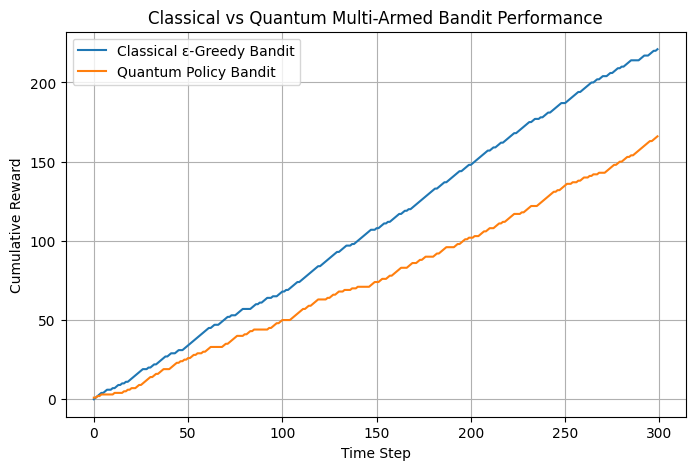

In [10]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    label="Classical ε-Greedy Bandit"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    label="Quantum Policy Bandit"
)

plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.title("Classical vs Quantum Multi-Armed Bandit Performance")
plt.legend()
plt.grid(True)
plt.show()


### Bandit Action Probabilities Heatmap

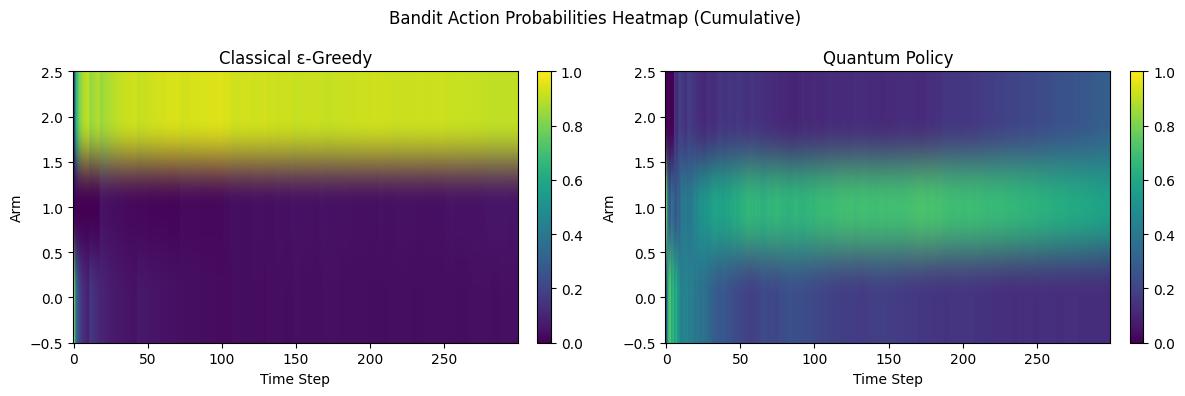

In [11]:
# Cumulative action-selection probabilities over time (per arm)

def cumulative_action_probs(actions, n_arms):
    actions = np.asarray(actions, dtype=int)
    T = len(actions)
    mat = np.zeros((n_arms, T))
    counts = np.zeros(n_arms, dtype=float)
    for t, a in enumerate(actions):
        counts[a] += 1.0
        mat[:, t] = counts / (t + 1)
    return mat

mat_classical = cumulative_action_probs(metrics_classical["actions"], N_ARMS)
mat_quantum = cumulative_action_probs(metrics_quantum["actions"], N_ARMS)

plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(mat_classical, aspect="auto", origin="lower")
ax1.set_title("Classical ε-Greedy")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Arm")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(mat_quantum, aspect="auto", origin="lower")
ax2.set_title("Quantum Policy")
ax2.set_xlabel("Time Step")
ax2.set_ylabel("Arm")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle("Bandit Action Probabilities Heatmap (Cumulative)")
plt.tight_layout()
plt.show()


### Bandit Cumulative Regret

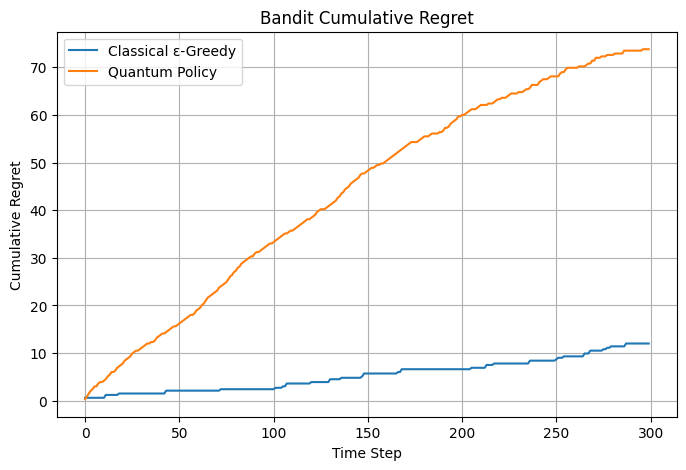

In [12]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["cumulative_regret"],
    label="Classical ε-Greedy"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["cumulative_regret"],
    label="Quantum Policy"
)

plt.xlabel("Time Step")
plt.ylabel("Cumulative Regret")
plt.title("Bandit Cumulative Regret")
plt.legend()
plt.grid(True)
plt.show()


### Quantum Circuit Execution Time

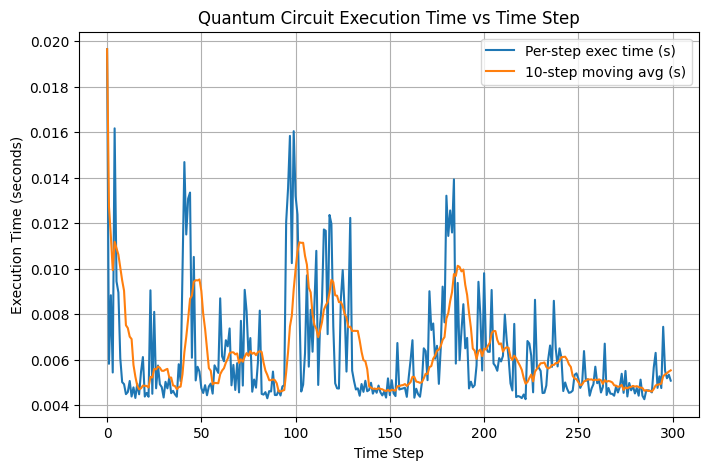

In [13]:
times = np.array(metrics_quantum["circuit_exec_time_s"], dtype=float)
steps = np.arange(len(times))

# Optional smoothing (moving average)
window = 10
if len(times) >= window:
    smooth = pd.Series(times).rolling(window=window, min_periods=1).mean().to_numpy()
else:
    smooth = times

plt.figure(figsize=(8, 5))
plt.plot(steps, times, label="Per-step exec time (s)")
plt.plot(steps, smooth, label=f"{window}-step moving avg (s)")

plt.xlabel("Time Step")
plt.ylabel("Execution Time (seconds)")
plt.title("Quantum Circuit Execution Time vs Time Step")
plt.legend()
plt.grid(True)
plt.show()


### Cell 10 — Final Results Table

In [14]:
results = pd.DataFrame({
    "Model": ["Classical Bandit", "Quantum Bandit"],
    "Total Reward": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ],
    "Average Reward per Step": [
        metrics_classical["performance"][-1] / TIME_STEPS,
        metrics_quantum["performance"][-1] / TIME_STEPS
    ]
})

results


,Model,Total Reward,Average Reward per Step
0,Classical Bandit,221,0.736667
1,Quantum Bandit,166,0.553333


**Paper framing:**
“Quantum policies model strategic decisions via entangled action representations.”